In [2]:
import os
import shutil
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import torch.nn.functional as F

In [5]:
zip_ref = zipfile.ZipFile('dataset.zip', 'r')
zip_ref.extractall('TMP')
zip_ref.close()

In [7]:
base_dir = '/content/TMP'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')
buffalo_dir = os.path.join(base_dir,'buffalo')
elephant_dir = os.path.join(base_dir, 'elephant')
rhino_dir = os.path.join(base_dir, 'rhino')
zebra_dir = os.path.join(base_dir, 'zebra')

In [8]:
os.mkdir(train_dir)
os.mkdir(validation_dir)

In [9]:
train_buffalo = os.path.join(train_dir, 'buffalo')
train_elephant = os.path.join(train_dir, 'elephant')
train_rhino = os.path.join(train_dir, 'rhino')
train_zebra = os.path.join(train_dir, 'zebra')

val_buffalo = os.path.join(validation_dir, 'buffalo')
val_elephant = os.path.join(validation_dir, 'elephant')
val_rhino = os.path.join(validation_dir, 'rhino')
val_zebra = os.path.join(validation_dir, 'zebra')

In [10]:
os.mkdir(train_buffalo)
os.mkdir(train_elephant)
os.mkdir(train_rhino)
os.mkdir(train_zebra)
os.mkdir(val_buffalo)
os.mkdir(val_elephant)
os.mkdir(val_rhino)
os.mkdir(val_zebra)

In [13]:
train_buffalo_dir, val_buffalo_dir = train_test_split(os.listdir(buffalo_dir), test_size = 0.25)
train_elephant_dir, val_elephant_dir = train_test_split(os.listdir(elephant_dir), test_size = 0.25)
train_rhino_dir, val_rhino_dir = train_test_split(os.listdir(rhino_dir), test_size = 0.25)
train_zebra_dir, val_zebra_dir = train_test_split(os.listdir(zebra_dir), test_size = 0.25)

In [16]:
for file in train_buffalo_dir:
  shutil.copy(os.path.join(buffalo_dir, file), os.path.join(train_buffalo, file))
for file in train_elephant_dir:
  shutil.copy(os.path.join(elephant_dir,file), os.path.join(train_elephant,file))
for file in train_rhino_dir:
  shutil.copy(os.path.join(rhino_dir,file), os.path.join(train_rhino,file))
for file in train_zebra_dir:
  shutil.copy(os.path.join(zebra_dir,file), os.path.join(train_zebra,file))

for file in val_buffalo_dir:
  shutil.copy(os.path.join(buffalo_dir, file), os.path.join(val_buffalo,file))
for file in val_elephant_dir:
  shutil.copy(os.path.join(elephant_dir,file), os.path.join(val_elephant,file))
for file in val_rhino_dir:
  shutil.copy(os.path.join(rhino_dir,file), os.path.join(val_rhino,file))
for file in val_zebra_dir:
  shutil.copy(os.path.join(zebra_dir,file), os.path.join(val_zebra,file))

In [101]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [102]:
training_dataset = datasets.ImageFolder('/content/TMP/train', transform=transform)
validation_dataset = datasets.ImageFolder('/content/TMP/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [103]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [104]:
classes = ['buffalo', 'elephant', 'rhino', 'zebra']

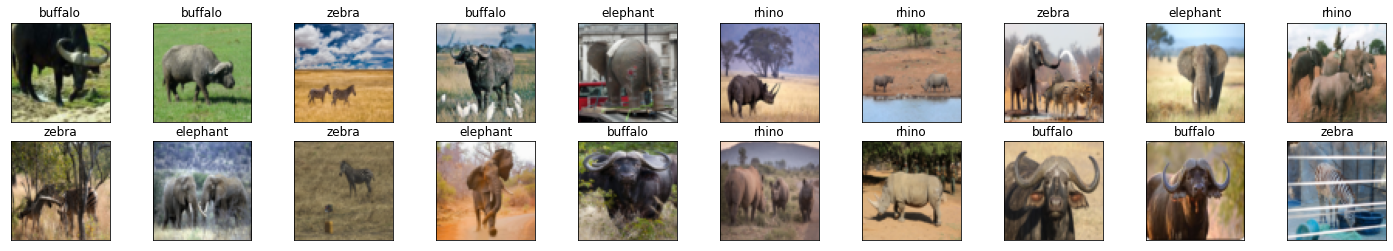

In [82]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [84]:
device

device(type='cuda', index=0)

In [105]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        
        self.categories = 4
        
        self.block1 = nn.Sequential(  
            nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 2)) 
        
        self.block2 = nn.Sequential(          
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = 2))
            
        self.block3 = nn.Sequential(              
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size = 2))


        
        self.classify = nn.Sequential(

            nn.Dropout(p=0.2),
            nn.Linear(in_features = 512 * 8 * 8, out_features = 512),
            nn.LeakyReLU(inplace = True),

            nn.Linear(in_features = 512, out_features = self.categories),
        )       

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = x3.view(x3.size(0), -1)
        x5 = self.classify(x4)
        return x5

In [106]:
import torch.nn as nn

#n_inputs = model.classifier[3].in_features # Change number, look at the latest layer!
#last_layer = nn.Linear(n_inputs, len(classes))
#model.classifier[3] = last_layer
#model.to(device)
#print(model)

model = Model().to(device)
model

Model(
  (block1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [107]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [108]:
%%time
epochs = 1

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_accuracy = running_corrects.float()/len(training_loader.dataset)
    
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader.dataset)
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_accuracy)
    print('epoch:', e)
    print('Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 0
Training Loss: 0.0380, Training Accuracy: 0.5119, Validation Loss: 0.0369, Validation Accuracy: 0.5203
CPU times: user 25.2 s, sys: 1.01 s, total: 26.2 s
Wall time: 26.1 s


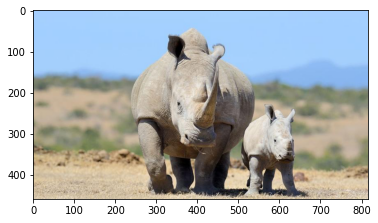

In [109]:
import requests
from PIL import Image
import PIL.ImageOps
#url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRTBoi-Jsq6BR1-nogR2VankoDWnMTMzcayaLx_f9UHTPgteh_ZFA'
#response = requests.get(url, stream=True)
img = Image.open('/content/TMP/rhino/001.jpg')
plt.imshow(img)

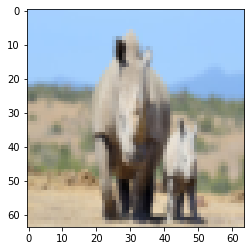

In [110]:
img = transform(img)
plt.imshow(im_convert(img))

In [111]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

rhino
